In [ ]:
!pip install gymnasium
!pip install pygame

# Carga y exploración de un entorno de Gymnasium

In [1]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed

# Parámetros globales
SEED = 42
ACCIONES = ['←', '↓', '→', '↑']

# -------------------- POLÍTICAS --------------------

def epsilon_soft_policy(Q: np.ndarray, epsilon: float, state: int, nA: int) -> np.ndarray:
    """Devuelve una política epsilon-soft como vector de probabilidades."""
    policy = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    policy[best_action] += 1.0 - epsilon
    return policy

def seleccionar_accion(Q: np.ndarray, epsilon: float, state: int, nA: int) -> int:
    """Devuelve una acción siguiendo política epsilon-greedy."""
    policy = epsilon_soft_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=policy)

# -------------------- VISUALIZACIÓN DE POLÍTICA --------------------

def representar_politica_greedy(agente, mostrar_como_grid=True):
    """Ejecuta y visualiza la política greedy aprendida."""
    env = agente.env
    Q = agente.Q
    desc = env.unwrapped.desc

    state, _ = env.reset()
    done = False
    total_reward = 0
    acciones_realizadas = []
    tableros = []

    while not done:
        action = np.argmax(Q[state])
        acciones_realizadas.append(ACCIONES[action])
        tableros.append(tablero_con_emojis(desc, state))
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    tableros.append(tablero_con_emojis(desc, state))  # último estado

    if mostrar_como_grid:
        mostrar_tableros_en_grid(tableros)
    else:
        for tablero in tableros:
            display(HTML(f"<pre style='font-size: 24px'>{tablero}</pre>"))

    print(f"Recompensa total: {total_reward}")
    print(f"Secuencia de acciones: {acciones_realizadas}")

def tablero_con_emojis(desc: np.ndarray, pos_agente: int) -> str:
    """Devuelve una representación del entorno con emojis."""
    EMOJI_MAP = {b'S': '🚩', b'F': '🧊', b'H': '🕳️', b'G': '🏁'}
    AGENTE = '🤖'
    tablero = ""

    for i, fila in enumerate(desc):
        for j, celda in enumerate(fila):
            idx = i * desc.shape[1] + j
            tablero += AGENTE if idx == pos_agente else EMOJI_MAP[celda]
        tablero += "\n"
    return tablero

def mostrar_tableros_en_grid(tableros: list[str], columnas: int = 4):
    """Muestra múltiples tableros en una cuadrícula HTML."""
    html = "<table><tr>"
    for i, t in enumerate(tableros):
        html += f"<td><pre style='font-size: 14px'>{t}</pre></td>"
        if (i + 1) % columnas == 0:
            html += "</tr><tr>"
    html += "</tr></table>"
    display(HTML(html))

def dibujar_politica_optima(agente):
    """Dibuja con matplotlib la política óptima aprendida."""
    Q = agente.Q
    desc = agente.env.unwrapped.desc
    num_rows, num_cols = desc.shape

    simbolos = [
        'X' if np.all(fila == 0) else ACCIONES[np.argmax(fila)]
        for fila in Q
    ]

    matriz = np.array(simbolos).reshape(num_rows, num_cols)

    fig, ax = plt.subplots(figsize=(num_cols, num_rows))
    ax.set_xticks(np.arange(num_cols))
    ax.set_yticks(np.arange(num_rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(-.5, num_cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, num_rows, 1), minor=True)
    ax.grid(which='minor', color='black', linewidth=1)

    for i in range(num_rows):
        for j in range(num_cols):
            ax.text(j, i, matriz[i, j], ha='center', va='center', fontsize=16)

    ax.invert_yaxis()
    plt.title("Política óptima")
    plt.show()

# -------------------- MÉTRICAS Y RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la proporción de éxitos por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(range(len(agente.stats)), agente.stats)
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.plot(agente.episode_lengths)
    plt.title("Longitud por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente(agente):
    """Muestra la política seguida, la Q aprendida y la política óptima."""
    representar_politica_greedy(agente)
    
    print("\nTabla Q aprendida:")
    columnas = ['← Izquierda', '↓ Abajo', '→ Derecha', '↑ Arriba']
    tabla_q = pd.DataFrame(agente.Q, columns=columnas)
    tabla_q.index.name = 'Estado'
    display(tabla_q.round(3))

    print("\nPolítica óptima aprendida:")
    dibujar_politica_optima(agente)

# Objeto AgenteMonteCarlo

In [2]:
class AgenteSARSA:
    def __init__(self, env, epsilon=1.0, alpha=0.1, discount_factor=1.0, decay=True):
        self.env = env
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        self.decay = decay
        self.nA = env.action_space.n
        self.Q = np.zeros([env.observation_space.n, self.nA])
        self.stats = []
        self.episode_lengths = []

    def entrenar(self, num_episodes=50000, mostrar_barra=True):

        random.seed(SEED)
        np.random.seed(SEED)
        
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            state, _ = self.env.reset()
            done = False

            if self.decay:
                self.epsilon = min(1.0, 1000.0 / (t + 1))

            action = seleccionar_accion(self.Q, self.epsilon, state, self.nA)
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                pasos += 1
                total_reward += reward

                if not done:
                    next_action = seleccionar_accion(self.Q, self.epsilon, next_state, self.nA)
                    td_target = reward + self.discount_factor * self.Q[next_state, next_action]
                else:
                    td_target = reward  # no hay estado siguiente

                td_error = td_target - self.Q[state, action]
                self.Q[state, action] += self.alpha * td_error

                state = next_state
                action = next_action if not done else None

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.Q


# Entorno 4X4

In [3]:
def evaluar_configuracion(params, map_name):
    if isinstance(map_name, str):
        env = gym.make("FrozenLake-v1", is_slippery=False, map_name=map_name)
    else:
        env = gym.make("FrozenLake-v1", is_slippery=False, desc=map_name)
    alpha, gamma, epsilon, decay = params
    agente = AgenteSARSA(env, alpha=alpha, epsilon=epsilon, discount_factor=gamma, decay=decay)
    agente.entrenar(num_episodes=20000, mostrar_barra=False)
    recompensa_final = agente.stats[-1]
    return (alpha, gamma, epsilon, decay, recompensa_final)

def grid_search(map_name):
    # Espacio de búsqueda
    alphas = [0.05, 0.1, 0.25, 0.5]
    gammas = np.linspace(0.1, 1.0, 10)
    epsilons = np.linspace(0.1, 1.0, 10)
    
    # Combinaciones con decay = False (usar todos los epsilon)
    combinaciones_sin_decay = [(a, g, e, False) for a, g, e in product(alphas, gammas, epsilons)]
    
    # Combinaciones con decay = True (epsilon ignorado, se pone a 0.0)
    combinaciones_con_decay = [(a, g, 0.0, True) for a, g in product(alphas, gammas)]
    
    # Unir ambas listas
    combinaciones = combinaciones_sin_decay + combinaciones_con_decay

    mejor_config = None
    mejor_recompensa = -float('inf')
    resultados = []

    print("🔍 Buscando la mejor combinación de hiperparámetros...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo, map_name) for combo in combinaciones]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, decay_flag, recompensa = future.result()
            resultados.append((alpha, gamma, epsilon, decay_flag, recompensa))

            if recompensa > mejor_recompensa:
                mejor_recompensa = recompensa
                mejor_config = (alpha, gamma, epsilon, decay_flag)

    print("\n✅ Mejor configuración encontrada:")
    print(f" alpha = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, decay = {mejor_config[3]}")
    print(f"  → Recompensa media final: {mejor_recompensa:.4f}")

In [4]:
grid_search("4x4")

🔍 Buscando la mejor combinación de hiperparámetros...



Progreso: 100%|███████████████████████████████████████████████████████████████████████| 440/440 [19:23<00:00,  2.64s/it]


✅ Mejor configuración encontrada:
 alpha = 0.05, γ = 0.7000000000000001, ε = 0.0, decay = True
  → Recompensa media final: 0.7913


In [5]:
# Ejecución de ejemplo
env_4x4 = gym.make("FrozenLake-v1", is_slippery=False)
env_4x4.reset(seed=SEED)
agente_4x4 = AgenteSARSA(env_4x4, alpha=0.05, discount_factor=0.7, decay=True)
agente_4x4.entrenar(num_episodes=200000)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [01:04<00:00, 3082.54it/s]


array([[0.11602062, 0.16731114, 0.15765679, 0.11530848],
       [0.11298071, 0.        , 0.2348531 , 0.16578034],
       [0.16128934, 0.33935844, 0.16401137, 0.23739851],
       [0.23684103, 0.        , 0.03043284, 0.0108334 ],
       [0.16637617, 0.23836482, 0.        , 0.11321891],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.48764443, 0.        , 0.22982781],
       [0.        , 0.        , 0.        , 0.        ],
       [0.23831714, 0.        , 0.33938485, 0.1621732 ],
       [0.23262993, 0.48452645, 0.46111751, 0.        ],
       [0.33622348, 0.69346286, 0.        , 0.33725235],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.48861548, 0.69569172, 0.33121844],
       [0.48336877, 0.69999991, 1.        , 0.47988892],
       [0.        , 0.        , 0.        , 0.        ]])

# Gráfica de Proporción de aciertos por número de episodios

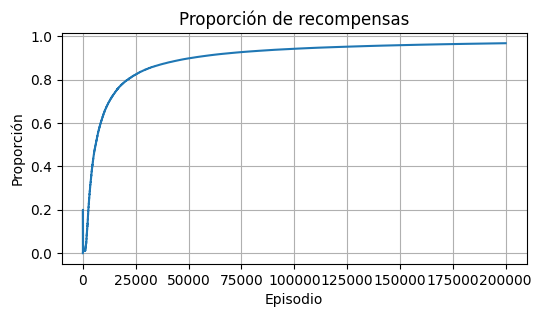

In [6]:
graficar_recompensas(agente_4x4)

# Gráfica de longitud de los episodios

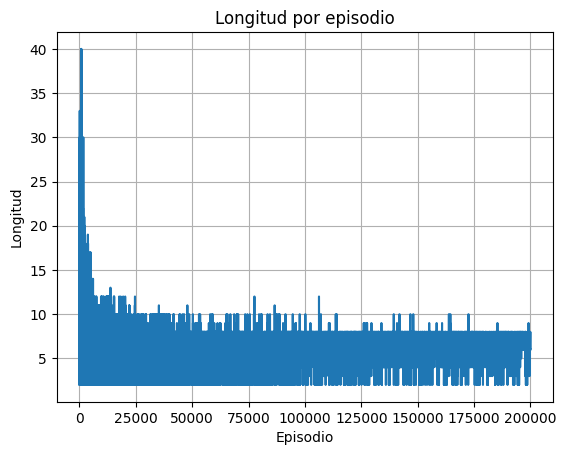

In [7]:
graficar_longitud_episodios(agente_4x4)

## Interpretación de las gráficas:

1. La primera gráfica muestra la proporción acumulada de recompensas por episodio. Se observa una tendencia ascendente que se estabiliza, lo cual indica que el agente ha aprendido una política que mejora progresivamente su rendimiento. La proporción final cercana a 0.5 sugiere que logra alcanzar el objetivo en aproximadamente la mitad de los episodios.

2. La segunda gráfica representa la longitud de cada episodio (número de pasos hasta terminar). Inicialmente, el agente necesita más pasos y los episodios son inestables. A medida que aprende, la longitud tiende a estabilizarse y reducirse, lo cual indica que el agente encuentra trayectorias más eficientes o termina el episodio de forma más consistente.

Ambas gráficas son complementarias: mientras que una muestra la eficacia del agente, la otra muestra su eficiencia y estabilidad.

Recompensa total: 1.0
Secuencia de acciones: ['↓', '↓', '→', '↓', '→', '→']

Tabla Q aprendida:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.116,0.167,0.158,0.115
1,0.113,0.000,0.235,0.166
2,0.161,0.339,0.164,0.237
3,0.237,0.000,0.030,0.011
4,0.166,0.238,0.000,0.113
5,0.000,0.000,0.000,0.000
6,0.000,0.488,0.000,0.230
7,0.000,0.000,0.000,0.000
8,0.238,0.000,0.339,0.162



Política óptima aprendida:


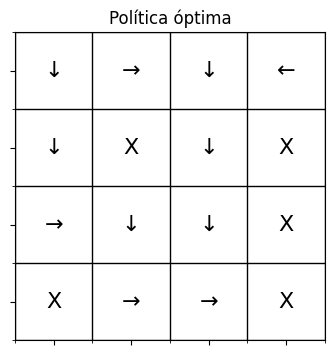

In [8]:
mostrar_resultados_agente(agente_4x4)

# Entorno 8x8

In [9]:
grid_search("8x8")

🔍 Buscando la mejor combinación de hiperparámetros...



Progreso:  10%|██████▋                                                               | 42/440 [11:10<1:45:50, 15.96s/it]Process ForkProcess-20:
Process ForkProcess-29:

Process ForkProcess-27:
Process ForkProcess-18:
Process ForkProcess-24:
Process ForkProcess-22:
Process ForkProcess-32:
Process ForkProcess-26:
Traceback (most recent call last):

KeyboardInterrupt



In [34]:
# Ejecución de ejemplo
env_8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8")
env_8x8.reset(seed=SEED)
agente_8x8 = AgenteSARSA(env_8x8, epsilon=0.1, alpha=0.05, discount_factor=0.9, decay=True)
agente_8x8.entrenar(num_episodes=200000)

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [06:03<00:00, 549.45it/s]


array([[2.26787762e-01, 2.46298932e-01, 2.52744639e-01, 2.26913180e-01],
       [2.24642835e-01, 2.73264552e-01, 2.81083123e-01, 2.51966463e-01],
       [2.49635970e-01, 3.06412597e-01, 3.13036274e-01, 2.80231809e-01],
       [2.77388201e-01, 3.35510409e-01, 3.48114616e-01, 3.11600345e-01],
       [3.08537992e-01, 3.80751363e-01, 3.86839496e-01, 3.46483868e-01],
       [3.42655982e-01, 4.21912849e-01, 4.29493734e-01, 3.84741390e-01],
       [3.80546845e-01, 4.76307082e-01, 4.67601881e-01, 4.26758160e-01],
       [2.31032900e-01, 5.27750948e-01, 2.72914022e-01, 3.07865088e-01],
       [1.21989020e-01, 2.53993714e-02, 2.78029622e-01, 1.19248811e-01],
       [1.65244258e-01, 9.28191589e-02, 3.08395786e-01, 1.81427837e-01],
       [2.30751196e-01, 1.56226269e-01, 3.44884126e-01, 2.43695526e-01],
       [2.80436816e-01, 0.00000000e+00, 3.85693122e-01, 2.91177007e-01],
       [3.44818408e-01, 4.19403303e-01, 4.28684022e-01, 3.42390604e-01],
       [3.80776274e-01, 4.67556371e-01, 4.76329246e

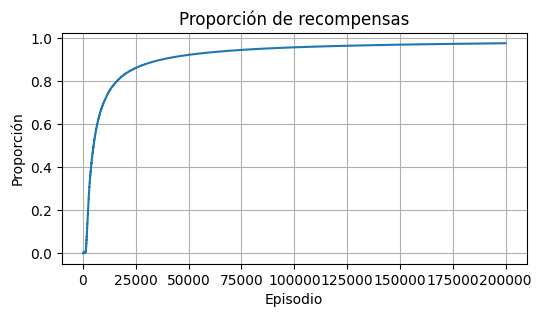

In [35]:
graficar_recompensas(agente_8x8)

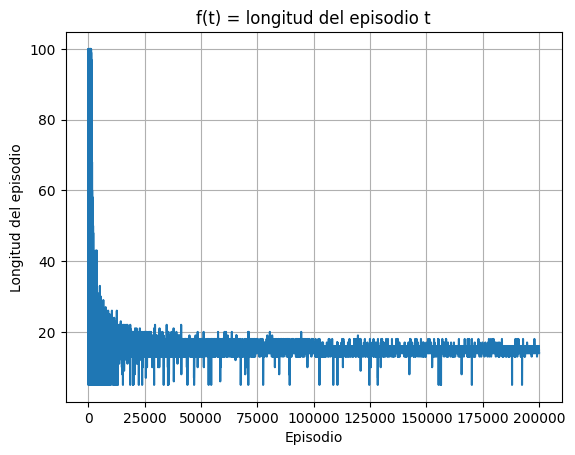

In [36]:
graficar_longitud_episodios(agente_8x8)

In [37]:
mostrar_resultados_agente(agente_8x8)

Recompensa total siguiendo la política greedy: 1.0
Secuencia de acciones tomadas: ['→', '→', '→', '→', '→', '→', '↓', '→', '↓', '↓', '↓', '↓', '↓', '↓']
Valores Q aprendidos por estado y acción:


,← Izquierda,↓ Abajo,→ Derecha,↑ Arriba
Estado,,,,
0,0.227,0.246,0.253,0.227
1,0.225,0.273,0.281,0.252
2,0.250,0.306,0.313,0.280
3,0.277,0.336,0.348,0.312
4,0.309,0.381,0.387,0.346
...,...,...,...,...
59,0.000,0.000,0.000,0.000
60,0.000,0.000,0.000,0.000
61,0.000,0.000,0.000,0.000



Política óptima aprendida (mejor acción por estado):


,Mejor acción,Estado siguiente
Estado 0,→,Estado 1
Estado 1,→,Estado 2
Estado 2,→,Estado 3
Estado 3,→,Estado 4
Estado 4,→,Estado 5
...,...,...
Estado 59,X,-
Estado 60,X,-
Estado 61,X,-
Estado 62,X,-
